<a href="https://colab.research.google.com/github/Ulises-Diaz/ViT-projects/blob/main/ViT_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:


# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")




[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


### 0. Setting for ViT transformer

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 4356 (delta 154), reused 119 (delta 119), pack-reused 4171 (from 3)
Receiving objects: 100% (4356/4356), 654.37 MiB | 29.44 MiB/s, done.
Resolving deltas: 100% (2583/2583), done.
Updating files: 100% (248/248), done.


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Get data



In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors

In [7]:
# Create image size (from table 3 in the ViT paper)

IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                       transforms.ToTensor()
                                       ])
print(f'Manually Created transforms: {manual_transforms}')


Manually Created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Set batch Size

BATCH_SIZE = 32 #Change for ViT paper

# Create data loaders

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms, # use manually created transforms
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79d271002d40>,
 ['pizza', 'steak', 'sushi'])

In [12]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from scratch
image, label = image_batch [0], label_batch [0]

image.shape , label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

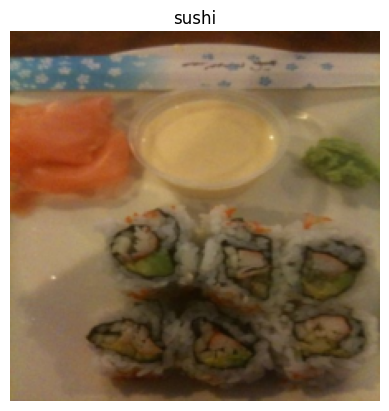

In [13]:
plt.imshow(image.permute(1 , 2 , 0)) # rearrange image dimensions
plt.title(class_names[label])
plt.axis(False)

#### Replicating ViT architecture

Need :
* Patch Embedding : Turn image into embedded patches
* Transformer encoder layer (This is of alternating a MSAwith a MLP block)
* Stack multiple transformer encoder layer on top of each other
* MLP head
* Put it all together

#### 1. Make Patchembedding layer

In [17]:
#  1. Create a class


class PatchEmbedding(nn.Module):
  '''

  Turns a 2D input image into a 1D sequence learnable embedding vector

  Args :
    * in_channels (int): # Color channels for the input image
    * patch_size (int) : Size patches to conveert input image
    * emedding_dim (int) : Size of embedding to turn image into

  '''

  # 2. Initialize the class
  def __init__(self,
               in_channels : int = 3,
               patch_size : int = 3,
               embedding_dim : int = 768):
    super().__init__()
      # 3. Create a layer to turn image into patches
    self.patcher = nn.Conv2d(in_channels = in_channels ,
                               out_channels = embedding_dim ,
                               kernel_size = patch_size,
                               stride = patch_size,
                               padding= 0)

    # 4. Create a layer to flatten the patch feature maps into a single dimensions
    self.flatten = nn.Flatten (start_dim = 2, #only flatten the feature map
                               end_dim = 3)


  # 5. Forward pass
  def forward (self, x) :

    #Create assertion to check that inputs are correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f'Input image must be divisible by patch size'

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. COnfirm output shape has same order
    return x_flattened.permute(0,2,1)